# Bay Area Bike Share Analysis by Udacity 
## this project is part of Udacity Nanodegree Data Analyst course 

## Introduction

> **Tip**: Quoted sections like this will provide helpful instructions on how to navigate and use an iPython notebook.

[Bay Area Bike Share](http://www.bayareabikeshare.com/) is a company that provides on-demand bike rentals for customers in San Francisco, Redwood City, Palo Alto, Mountain View, and San Jose. Users can unlock bikes from a variety of stations throughout each city, and return them to any station within the same city. Users pay for the service either through a yearly subscription or by purchasing 3-day or 24-hour passes. Users can make an unlimited number of trips, with trips under thirty minutes in length having no additional charge; longer trips will incur overtime fees.

Why I wanted to analyse the data?
**Answer**: from Business perspective, I would like to find out what is the location with maximum sales.what is the location where sales are low.what are most popular routes? what is the average duration? from customer end point I would like to know availability of cycle. number of available cycles and how far is the cycle station from me. 


## Using Visualizations to Communicate Findings in Data


In 2014, Bay Area Bike Share held an [Open Data Challenge](http://www.bayareabikeshare.com/datachallenge-2014) to encourage data analysts to create visualizations based on their open data set. 

How will it help?

**Answer**: The mostinteresting visulization is provided by average rides per city. In this visualization, you can select the city to see usage patterns. this visualization is great for the business as it shows where the number of rides is more? where do they need to build more docks? where do they have to ensure availability throughout the day?
SF,SJ has more number of customers using the service. thus business should ensure that they meet the customer demand throughout the week so that customers are never denied service due to no availibility. thus this visualization answers my question as a customer and also as business analyst.

other graph that has efficiently depicted user patterns is the graph of pupular cities.(start & end). as I user if I am travelling to a popoular city, I would want to ensure that the cycle is available for me. if I am travelling to a less popular destinnaation, I would not be bothered much as I know that there is high possibility of finding a cycle for my ride.

Rides by hour, rides by duration visualizations were insightful. Average rides per day graph was helpful too.

In [4]:
# import all necessary packages and functions.
import csv
from datetime import datetime
import numpy as np
import pandas as pd
from babs_datacheck import question_3
from babs_visualizations import usage_stats, usage_plot
from IPython.display import display
%matplotlib inline

In [5]:
# file locations
file_in  = '201402_trip_data.csv'
file_out = '201309_trip_data.csv'

with open(file_out, 'w') as f_out, open(file_in, 'r') as f_in:
    # set up csv reader and writer objects
    in_reader = csv.reader(f_in)
    out_writer = csv.writer(f_out)

    # write rows from in-file to out-file until specified date reached
    while True:
        datarow = next(in_reader)
        # trip start dates in 3rd column, m/d/yyyy HH:MM formats
        if datarow[2][:9] == '10/1/2013':
            break
        out_writer.writerow(datarow)

### Condensing the Trip Data

Sample data:

In [6]:
sample_data = pd.read_csv('201309_trip_data.csv')

display(sample_data.head())

,Trip ID,Duration,Start Date,Start Station,Start Terminal,End Date,End Station,End Terminal,Bike #,Subscription Type,Zip Code
0,4576,63,8/29/2013 14:13,South Van Ness at Market,66,8/29/2013 14:14,South Van Ness at Market,66,520,Subscriber,94127
1,4607,70,8/29/2013 14:42,San Jose City Hall,10,8/29/2013 14:43,San Jose City Hall,10,661,Subscriber,95138
2,4130,71,8/29/2013 10:16,Mountain View City Hall,27,8/29/2013 10:17,Mountain View City Hall,27,48,Subscriber,97214
3,4251,77,8/29/2013 11:29,San Jose City Hall,10,8/29/2013 11:30,San Jose City Hall,10,26,Subscriber,95060
4,4299,83,8/29/2013 12:02,South Van Ness at Market,66,8/29/2013 12:04,Market at 10th,67,319,Subscriber,94103


In [7]:
# Display the first few rows of the station data file.
station_info = pd.read_csv('201402_station_data.csv')
display(station_info.head())

# This function will be called by another function later on to create the mapping.
def create_station_mapping(station_data):
    """
    Create a mapping from station IDs to cities, returning the
    result as a dictionary.
    """
    station_map = {}
    for data_file in station_data:
        with open(data_file, 'r') as f_in:
            # set up csv reader object - note that we are using DictReader, which
            # takes the first row of the file as a header row for each row's
            # dictionary keys
            weather_reader = csv.DictReader(f_in)

            for row in weather_reader:
                station_map[row['station_id']] = row['landmark']
    return station_map

,station_id,name,lat,long,dockcount,landmark,installation
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013


In [8]:
def summarise_data(trip_in, station_data, trip_out):
    """
    This function takes trip and station information and outputs a new
    data file with a condensed summary of major trip information. The
    trip_in and station_data arguments will be lists of data files for
    the trip and station information, respectively, while trip_out
    specifies the location to which the summarized data will be written.
    """
    # generate dictionary of station - city mapping
    station_map = create_station_mapping(station_data)
    
    with open(trip_out, 'w') as f_out:
        # set up csv writer object        
        out_colnames = ['duration', 'start_date', 'start_year',
                        'start_month', 'start_hour', 'weekday',
                        'start_city', 'end_city', 'subscription_type']        
        trip_writer = csv.DictWriter(f_out, fieldnames = out_colnames)
        trip_writer.writeheader()
        
        for data_file in trip_in:
            with open(data_file, 'r') as f_in:
                # set up csv reader object
                trip_reader = csv.DictReader(f_in)

                # collect data from and process each row
                for row in trip_reader:
                    new_point = {}
                    
                    # convert duration units from seconds to minutes
                    ### Question 3a: Add a mathematical operation below   ###
                    ### to convert durations from seconds to minutes.     ###
                    new_point['duration'] = float(row['Duration'])/60
                    
                    # reformat datestrings into multiple columns
                    ### Question 3b: Fill in the blanks below to generate ###
                    ### the expected time values.                         ###
                    trip_date = datetime.strptime(row['Start Date'], '%m/%d/%Y %H:%M')
                    new_point['start_date']  = trip_date.strftime('%Y-%m-%d')
                    new_point['start_year']  = trip_date.strftime('%Y')
                    new_point['start_month'] = trip_date.strftime('%m')
                    new_point['start_hour']  = trip_date.strftime('%H')
                    new_point['weekday']     = trip_date.strftime('%A')
                    
                    # remap start and end terminal with start and end city
                    new_point['start_city'] = station_map[row['Start Terminal']]
                    new_point['end_city'] = station_map[row['End Terminal']]
                    # two different column names for subscribers depending on file
                    if 'Subscription Type' in row:
                        new_point['subscription_type'] = row['Subscription Type']
                    else:
                        new_point['subscription_type'] = row['Subscriber Type']

                    # write the processed information to the output file.
                    trip_writer.writerow(new_point)

In [9]:
trip_data = pd.read_csv('201309_trip_summary.csv')

usage_stats(trip_data)

There are 27345 data points in the dataset.
The average duration of trips is 27.60 minutes.
The median trip duration is 10.72 minutes.
25% of trips are shorter than 6.82 minutes.
25% of trips are longer than 17.28 minutes.


array([  6.81666667,  10.71666667,  17.28333333])

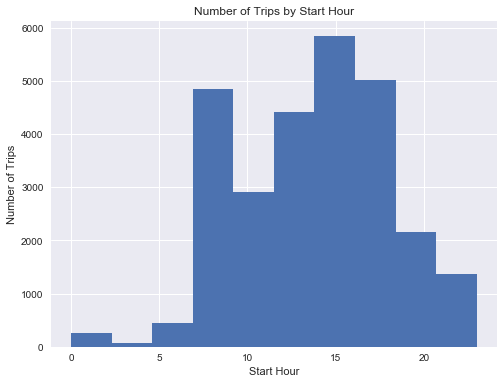

In [10]:
usage_plot(trip_data, 'start_hour')

Seems like there's about 50% more trips made by subscribers in the first month than customers. Let's try a different variable now. What does the distribution of trip durations look like?

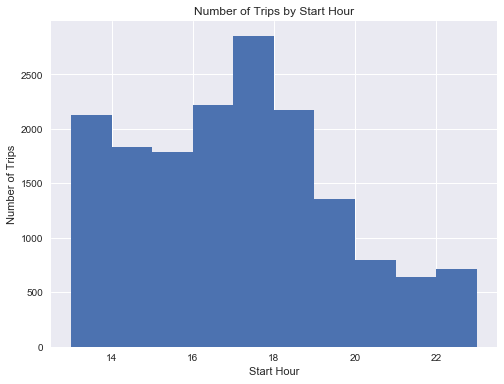

In [11]:
usage_plot(trip_data,'start_hour',['start_hour > 12'] )

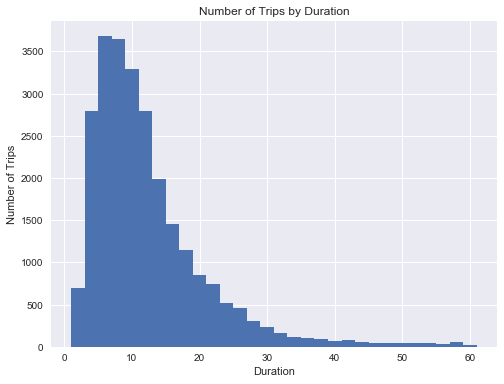

In [12]:
usage_plot(trip_data, 'duration', ['duration < 60'],bin_width = 2)

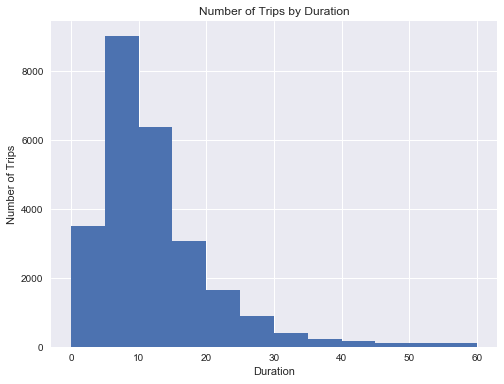

In [13]:
usage_plot(trip_data, 'duration', ['duration < 60'], boundary = 0, bin_width = 5)

**Question 4**: Which five-minute trip duration shows the most number of trips? Approximately how many trips were made in this range?

**Answer**: 5-to 10 minutes more than 8000 trips in this range

In [14]:
station_data = ['201402_station_data.csv',
                '201408_station_data.csv',
                '201508_station_data.csv' ]
trip_in = ['201402_trip_data.csv',
           '201408_trip_data.csv',
           '201508_trip_data.csv' ]
trip_out = 'babs_y1_y2_summary.csv'

# This function will take in the station data and trip data and
# write out a new data file to the name listed above in trip_out.
summarise_data(trip_in, station_data, trip_out)

In [15]:
trip_data = pd.read_csv('babs_y1_y2_summary.csv')
display(trip_data.head())

,duration,start_date,start_year,start_month,start_hour,weekday,start_city,end_city,subscription_type
0,1.050000,2013-08-29,2013,8,14,Thursday,San Francisco,San Francisco,Subscriber
1,1.166667,2013-08-29,2013,8,14,Thursday,San Jose,San Jose,Subscriber
2,1.183333,2013-08-29,2013,8,10,Thursday,Mountain View,Mountain View,Subscriber
3,1.283333,2013-08-29,2013,8,11,Thursday,San Jose,San Jose,Subscriber
4,1.383333,2013-08-29,2013,8,12,Thursday,San Francisco,San Francisco,Subscriber


In [16]:
usage_stats(trip_data)

There are 669959 data points in the dataset.
The average duration of trips is 18.47 minutes.
The median trip duration is 8.62 minutes.
25% of trips are shorter than 5.73 minutes.
25% of trips are longer than 12.58 minutes.


array([  5.73333333,   8.61666667,  12.58333333])

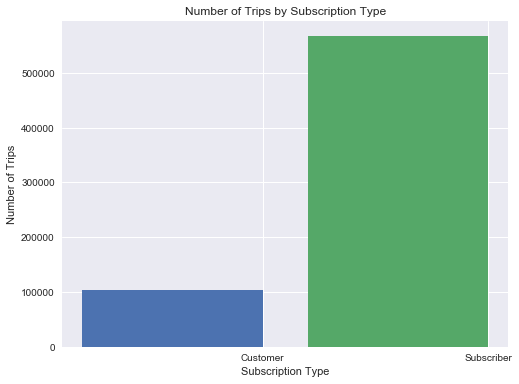

In [17]:
usage_plot(trip_data,'subscription_type')

Explore some different variables using the functions above and take note of some trends you find. Feel free to create additional cells if you want to explore the dataset in other ways or multiple ways.

> **Tip**: In order to add additional cells to a notebook, you can use the "Insert Cell Above" and "Insert Cell Below" options from the menu bar above. There is also an icon in the toolbar for adding new cells, with additional icons for moving the cells up and down the document. By default, new cells are of the code type; you can also specify the cell type (e.g. Code or Markdown) of selected cells from the Cell menu or the dropdown in the toolbar.

One you're done with your explorations, copy the two visualizations you found most interesting into the cells below, then answer the following questions with a few sentences describing what you found and why you selected the figures. Make sure that you adjust the number of bins or the bin limits so that they effectively convey data findings. Feel free to supplement this with any additional numbers generated from `usage_stats()` or place multiple visualizations to support your observations.

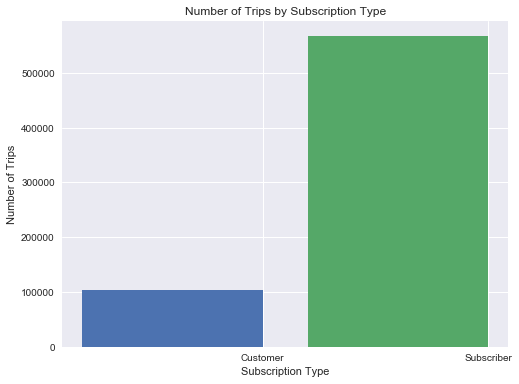

In [21]:
# Final Plot 1
usage_plot(trip_data,'subscription_type')

**Question 5a**: What is interesting about the above visualization? Why did you select it?

**Answer**: It shows that most of the customers who are driving the revenue of this business are Subscibers. but there are less number of trips by short-time-users. if we offer coupon/indentives to short-time customers we can expect more number of trips from them as well. most of the marketing budget should be spent promoting cycling in non-subscriber customer segment. on  which can ultimately help business. Next business strtegy should be based arount this statistics.

I selected this visualization as the business strategy can be easity devised from this visualization. this is very straight forward, easy to interpret and finding solutions to results reflected can be done in effective ways for that business.

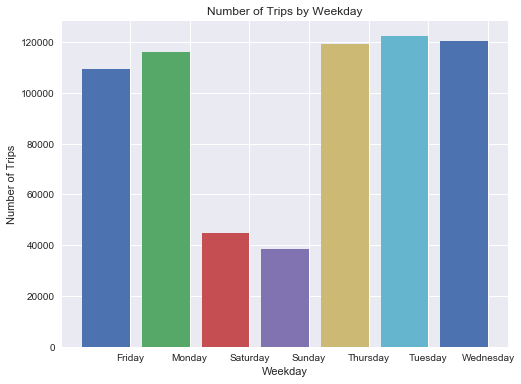

In [22]:
# Final Plot 2
usage_plot(trip_data,'weekday')

**Question 5b**: What is interesting about the above visualization? Why did you select it?

**Answer**: it shows that, usage is mostly done on weekdays. we can estimate that most of our customers are emplyees. we can use some marketing promotions to boost sales on weekends as well.

## Conclusions

Congratulations on completing the project! This is only a sampling of the data analysis process: from generating questions, wrangling the data, and to exploring the data. Normally, at this point in the data analysis process, you might want to draw conclusions about our data by performing a statistical test or fitting the data to a model for making predictions. There are also a lot of potential analyses that could be performed on the data which are not possible with only the code given. Instead of just looking at number of trips on the outcome axis, you could see what features affect things like trip duration. We also haven't looked at how the weather data ties into bike usage.

**Question 6**: Think of a topic or field of interest where you would like to be able to apply the techniques of data science. What would you like to be able to learn from your chosen subject?

**Answer**: AirBnB data set. I would like to find out how many houses are below certain proce range. what is the maximum occupancy what's the duration of each stay? how is the host rating related to number of booking host has.etc!

